# Describing model predictions when have categorical features, using SHAP values: Using Titanic survival as an example use case.

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values, so you can understand what the model used to obtain it's prediction.

SHAP values are calculated for a fitted model. These are in the same units as the model output (for XGBoost these are in log odds - they are additive).

SHAP values provide a base value which is the same values for all of the instances. This values represents the models best guess for any instance without any extra knowledge about the instance. The "expected value". In addition to this, a SHAP value is calculated per feature. These are instance dependent as they also capture the interactions between pairs of feature values.

This notebook extends notebook 90 by exploring how to interpret SHAP values when there are categorical features in the dataset. To fit a XGBoost model to a dataset with categorical features, we need to represent them as one-hot encoded features. This results in a separate feature for each level of the categorical variable. This is all well and good for fitting the model, but one feature is now represented by a SHAP value per level. How do you interpret all of these SHAP values? 

Here we fit an XGBoost model to the Titanic dataset, to predict whether a passenger survives from the values of four features, three which are continuous (gender, age, ticket class) and one categorical feature with three levels represented as one-hot features(port embarked: Southampton,  Cherbourg, Queenstown). We calculate the SHAP values of this fitted model and show two ways to represent their values: keep them separate, or join them todgether.how to communicate what they mean d) to present all of these values in order to gain the most insight into how the model is working - using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a and https://towardsdatascience.com/shap-for-categorical-features-7c63e6a554ea

## Model and data

XGBoost models were trained on all of the data (not split into training and test set). The six features in the model are:

* male: genger of the passenger (0 = female, 1 = male)
* Pclass: Class of the ticket (1 = first, 2 = second, 3 = third class)
* Age: Age of passenger, in years
* Embarked_S: Passenger embarked at Southampton
* Embarked_C: Passenger embarked at Cherbourg
* Embarked_Q: Passenger embarked at Queenstown

And one target feature:
* Survived: Did the passenger survive the sinking of the Titanic (0 = not survive, 1 = survive)

## Aims

* Fit XGBoost model using feature data to predict whether passenger survived
* Calculate the SHAP values when one-hot encoded features
* Understand the SHAP values when have one-hot encoded features
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* SHAP interactions are awesome! 
* Viewing them as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset.

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

# do we need these?
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
import xgboost as xgb

/home/kerry/anaconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/anaconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and process data

#### Download data

First we will download pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [2]:
download_required = False

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

#### Load data
Read in the dataset (already contains the one-hot encoding of the features)

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

#### Restrict data

Restrict to 4 features and target feature.

Use 3 continuous variables, and 1 categorical variable (with 3 levels) represented in it's one-hot encoded form.
And a binary target variable.

In [4]:
ohe_feature_names = ['male', 'Pclass', 'Age', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Survived']
data = data[ohe_feature_names]

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [5]:
# Use `survived` field as y, and drop for X
y = data['Survived'] # y = 'survived' column from 'data'
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column

Average survival (this is the expected outcome of each passenger, without knowing anything about the passenger)

In [6]:
print (f'Average survival: {round(y.mean(),2)}')

Average survival: 0.38


## Fit XGBoost model

We will fit a model to all of the data (rather than train/test splits used to assess accuracy).

In [7]:
#model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model = XGBClassifier(random_state=42)
model.fit(X, y)

[21:07:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each patient (in terms of the classification, and the probability of being in either class)

In [8]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [9]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.889


In [10]:
print(confusion_matrix(y, y_pred))
accuracy_score(y, y_pred)

[[520  29]
 [ 70 272]]


0.8888888888888888

## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

In [11]:
# Set up the method to estimate SHAP values for tree models and ensembles of
# trees
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer(X)

### Waterfall plot

Embarked is shown as it's one-hot encoded components. They each get their own SHAP value. For this instance we can see that the passenger embarked at Southampton (Embarked_S = 1). This contributes a small amount to the likelihood of not surviving. The fact that the passenger did not embark at C contributes a larger amount to the likelihood of not surviving, and the fact that the passeger did not embark at Q contributes a very small amount to the likelihood of surviving.

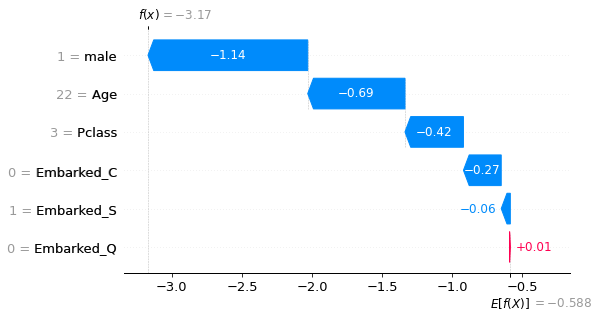

In [12]:
# waterfall plot
shap.plots.waterfall(shap_values[0], show=False)
plt.show()
#plt.savefig(path.format('standard_shap.png'),dpi=100,bbox_inches='tight')

# SHAP for catgeorical features 

We've seen above that the categorigcal feature represented as a one-hot encoded feature have a SHAP value for each of the one-hot encoded features.

Looking at them in isolation gives us the contribution of each in respect to the feature value.

As SHAP values are additive, we have the option of joining them together (summing each of the one-hot features) to give us the overall contribution of the whole feature, to be described as "the contribution of passenger embarking from Southampton, and not at the others".

Represent the dataset without one-hot encoded features (that is to represent Embarked as a single column, with a string per category: S, C, Q), and just the X features (remove the target feature)

Create dataset with Embarked column containing the string value in a single column - basically un-do the one-hot encoding of the Embarked column. This is to be used later.

In [13]:
# Setup conditions
conditions = [
   (data['Embarked_C'] == 1),
   (data['Embarked_Q'] == 1),
   (data['Embarked_S'] == 1)
]

# Setup new value for each condition
values = ['C', 'Q', 'S']

# Copy of original dataset
X_data_combined = data.copy(deep=True)

# Create new column
X_data_combined["Embarked"] = np.select(conditions, values)

# Drop the original one-hot encoded features
X_data_combined.drop(columns=['Embarked_C', 'Embarked_Q', 'Embarked_S'], inplace=True)

# Drop the target feature
X_data_combined.drop("Survived", axis=1, inplace = True)

# Drfine column order (with target feature at end)
#col_order = ['male', 'Pclass', 'Age', 'Embarked', 'Survived']

# Reorder columns
#data_combined = data_combined[col_order] 

# Store feature names for later
feature_names = X_data_combined.columns.values

# View first 5 rows
X_data_combined.head(5)

,male,Pclass,Age,Embarked
0,1.0,3.0,22.0,S
1,0.0,1.0,38.0,C
2,0.0,3.0,26.0,S
3,0.0,1.0,35.0,S
4,1.0,3.0,35.0,S


The SHAP values are returned in the same order as in the dataset. We are going to sum up the SHAP values for the one-hot encded features that represent the feature Embarked.

We need to match up the columns in the SHAP values and in the dataset. The SHAP values are returned in the same order as the dataset. Let's remind ourselves of what the shap_values Explainer object look like (for the first 5 rows):

In [14]:
print(shap_values[0:5])

.values =
array([[-1.1405869 , -0.41747785, -0.69435966, -0.2698082 ,  0.00518216,
        -0.06495818],
       [ 2.626636  ,  2.4683647 , -0.8261189 ,  0.08193731,  0.01741966,
         0.07263356],
       [ 1.6105285 , -0.70553905,  0.42194188, -0.05834208, -0.01360322,
        -0.1980037 ],
       [ 2.8425143 ,  2.5561671 ,  2.071535  , -0.04348096,  0.02041109,
        -0.03775589],
       [-1.2752291 , -1.246187  , -0.10405035, -0.07038384,  0.01380277,
         0.05198947]], dtype=float32)

.base_values =
array([-0.58842766, -0.58842766, -0.58842766, -0.58842766, -0.58842766],
      dtype=float32)

.data =
array([[ 1.,  3., 22.,  0.,  0.,  1.],
       [ 0.,  1., 38.,  1.,  0.,  0.],
       [ 0.,  3., 26.,  0.,  0.,  1.],
       [ 0.,  1., 35.,  0.,  0.,  1.],
       [ 1.,  3., 35.,  0.,  0.,  1.]])


In [15]:
# Want to do a culmulative sum on the SHAP values for each instance. 
# Need to know how many one-hot features there are per feature.
# So store the number of categories for each feature, apart from the final feature (as this will take the rest).
# If it's continuous feature, then have value 1.
#  Want result [1,1,1].

n_categories = []

for c in list(X_data_combined.columns)[:-1]:
    if  X_data_combined[c].dtype == object:
        n_categories.append(X_data_combined[c].nunique())
    else:
        n_categories.append(1)

Represent the shap_values.values as a value per feature (sum up the one-hot encoded features)

In [16]:
# Initialise list
new_shap_values = []

# For each set of feature SHAP values (for an instance)
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    # Add to list
    new_shap_values.append(values_sum)

print(f"Length of list {len(new_shap_values)}")
print(f"Sum of SHAP from two sources: {sum(new_shap_values[0])} & {sum(shap_values.values[0])}")
print(f"Sum of SHAP from two sources: {sum(new_shap_values[1])} & {sum(shap_values.values[1])}")
print(new_shap_values[1])

Length of list 891
Sum of SHAP from two sources: -2.5820085909217596 & -2.5820085909217596
Sum of SHAP from two sources: 4.4408723916858435 & 4.4408723916858435
[2.626636028289795, 2.468364715576172, -0.8261188864707947, 0.17199053429067135]


Create a new Explainer object (from teh existing one) and alter it to contian the information with the joined up one-hot encded features.

In [17]:
# Take deep copy of original Explainer object
shap_values_combined = copy.deepcopy(shap_values)

# Take copy of original Explainer object
shap_values_combined = shap_values

# Replace shap values
shap_values_combined.values = np.array(new_shap_values)

# Replace data with categorical feature values 
shap_values_combined.data = np.array(X_data_combined)

# Update feature names
shap_values_combined.feature_names = list(X_data_combined.columns)

View shap_values for first instance

In [18]:
shap_values_combined[0]

.values =
array([-1.14058685, -0.41747785, -0.69435966, -0.32958423])

.base_values =
-0.58842766

.data =
array([1.0, 3.0, 22.0, 'S'], dtype=object)

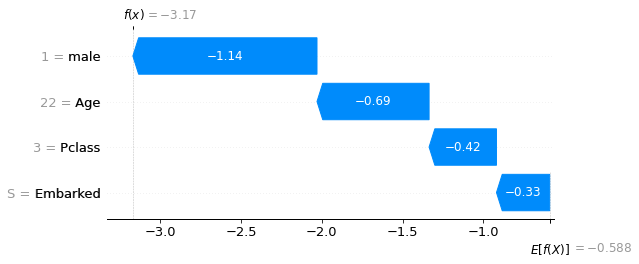

In [19]:
# waterfall plot
shap.plots.waterfall(shap_values_combined[0], show=False)
plt.show()
#plt.savefig(path.format('category_shap.png'),dpi=100,bbox_inches='tight')

Now we see Embarked as a single feature, with a single SHAP value. For this instance we can see that the passenger embarked at Southampton (Embarked = S). The SHAP value for this feature can be described as the contribution for the passenger embarking at Southampton, and not the rest. It contributes a relatively small amount to the likelihood of not surviving.

Now we look at the global picture

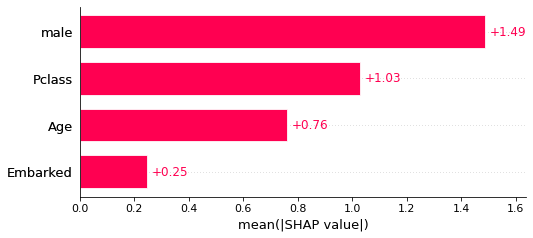

In [20]:
#Mean SHAP
shap.plots.bar(shap_values_combined,show=False)
plt.show()
#plt.savefig(path.format('mean_shap.png'),dpi=100,bbox_inches='tight')

The beeswarm can not show the feature value of categorical variables (for example Embarked) as it can only display a continuous scale. We can supplement this plot with a boxplot for each catrgorical feature (see below).

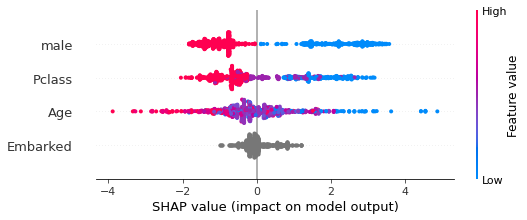

In [21]:
shap.plots.beeswarm(shap_values_combined, show=False)
plt.show()
#plt.savefig(path.format('beeswarm.png'),dpi=100,bbox_inches='tight')

Boxplot per categorical variable showing the spread of SHAP values for each categorical level.

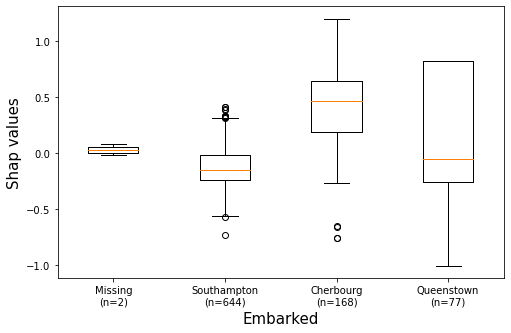

In [30]:
#get shaply values and data
embarked_values = shap_values_combined[:,"Embarked"].values
embarked_data = shap_values_combined[:,"Embarked"].data

#split odor shap values based on odor category
embarked_categories = list(set(embarked_data))

# Create dictionary for the Label with frequency, to use for the boxplot label
# KP NEED TO DO THIS
dict_freq = {}
#for o in embarked_categories:
#    dict_freq[f'{o}'] = []
    
embarked_groups = []
for o in embarked_categories:
    relevant_values = embarked_values[embarked_data == o]
    embarked_groups.append(relevant_values)
    # KP NEED TO DO THIS. ADD FREQ TO THE DICT
    dict_freq[f'{o}'] = relevant_values.shape
    
#replace categories with labels
embarked_labels = {'C':f'Cherbourg\n(n={dict_freq["C"][0]})',
                   'Q':f'Queenstown\n(n={dict_freq["Q"][0]})', 
                   'S':f'Southampton\n(n={dict_freq["S"][0]})',
                   '0':f'Missing\n(n={dict_freq["0"][0]})'}

labels = [embarked_labels[u] for u in embarked_categories]

#plot boxplot
plt.figure(figsize=(8, 5))

plt.boxplot(embarked_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Embarked',size=15)
plt.show()
#plt.savefig(path.format('boxplot.png'),dpi=100,bbox_inches='tight')

# To recap

We can fit a model to data that contains a categorical feature represented as one-hot encded features, and calculate their SHAP values and choose whether to represent them as their individual one-hot encoded components ("what each value contributes to the prediction"), or their combined effect ("what having this value, and not the others, contributes to the prediction").

Let's take a simple example and represent each of these options as an equation.

We have a continous feature "1" and a categorical feature "2" with two levels: A and B. For this example, let's assume that the instance is A, not B, for feature 2.

Here we will use this nomenclature:

P = Prediction\
B = Base value\
Sx = SHAP value for feature x (where x can be the continuous feature (such as 1), or one-hot encded categorical feature (such as 2A and 2B))

Option 1: Keeping the one-hot encoded features separate, we have:\

P = B + S1 + S2A + S2B

Option 2: We can sum the associated one-hot encoded features, and treat them as a single value (the combination of S2A and S2B gives the overall contribution for feature 2):\

P = B + S1 + S2A+B

where S2A+B = (S2A + S2B)

Describe S1 as “contribution from feature 1 on prediction”.
Describe S2A as “contribution from attending A on prediction”.
Describe S2B as “contribution from not attending B on prediction”.
Describe S2A+B as “contribution from attending A, and not the other, on prediction”.